## Setup

To access material for this workbook please execute the two notebook cells immediately below (e.g. use the shortcut <b>&lt;shift&gt;+&lt;return&gt;</b>). The first cell can be skipped if you are running this notebook locally and have already installed all the necessary packages. The second cell should print out "Your notebook is ready to go!"

In [1]:
if 'pyodide_kernel' in str(get_ipython()):  # specify packages to install under JupyterLite
    %pip install -q -r jlite-requirements.txt
elif 'google.colab' in str(get_ipython()):  # specify package location for loading in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    %run /content/drive/MyDrive/GARG_workshop/Notebooks/add_module_path.py
else:  # install packages on your local machine (-q = "quiet": don't print out installation steps)
    !python -m pip install -q -r https://github.com/ebp-nor/GARG/raw/main/jlite/requirements.txt

In [2]:
# Load questions etc for this workbook
from IPython.display import SVG
import tskit
import ARG_workshop
workbook = ARG_workshop.Workbook1D()
display(workbook.setup)

✅ Your notebook is ready to go!


### Using this workbook

This workbook is intended to be used by executing each cell as you go along. Code cells (like those above) can be modified and re-executed to perform different behaviour or additional analysis. You can use this to complete various programming exercises, some of which have associated questions to test your understanding. Exercises are marked like this:
<dl class="exercise"><dt>Exercise XXX</dt>
<dd>Here is an exercise: normally there will be a code cell below this box for you to work in</dd>
</dl>

# Workbook 1-D: Sites and mutations

So far we have been using _tskit_ to store genetic genealogies, but we have not tackled the topic of genetic variation. _Tskit_ stores genetic variation data in an unusual manner. Rather than storing a DNA sequence for each of the sample genomes, _tskit_ records genetic differences transmitted through the genealogy. In particular this is done by placing **mutations** on the genealogy.

Each mutation occupies a row of the *mutations table*. It is placed in the local tree by recording its associated *node*, and it is located along the genome by indexing into the *sites table*: each site in this table has a position and an ancestral state.

To illustrate, we'll use [msprime.sim_mutations()](https://tskit.dev/msprime/docs/stable/mutations.html) to add mutations to one of our simulated tree sequences, and display the *sites* and *mutations* tables,as well as the local trees. Various sorts of mutation such as indels, microsats, etc can be generated, but for the moment we'll just use single base pair substitutions, under the [Jukes & Cantor model](https://tskit.dev/msprime/docs/stable/api.html#msprime.JC69) in which there is an equal probability of mutating between any of the 4 bases.

id,position,ancestral_state,metadata
0,3,G,
1,9,T,
2,11,C,
3,23,C,
4,24,G,
5,47,G,
6,58,C,
7,95,A,
8,98,T,


id,site,node,time,derived_state,parent,metadata
0,0,12,5.62613580,A,-1,
1,1,17,17.55377898,G,-1,
2,2,12,2.00548389,A,-1,
3,3,5,4.08277149,A,-1,
4,4,17,13.38571557,C,-1,
5,5,10,5.25163818,T,-1,
6,6,16,11.16881700,A,-1,
7,7,7,0.81583747,T,-1,
8,8,16,20.79383023,G,-1,


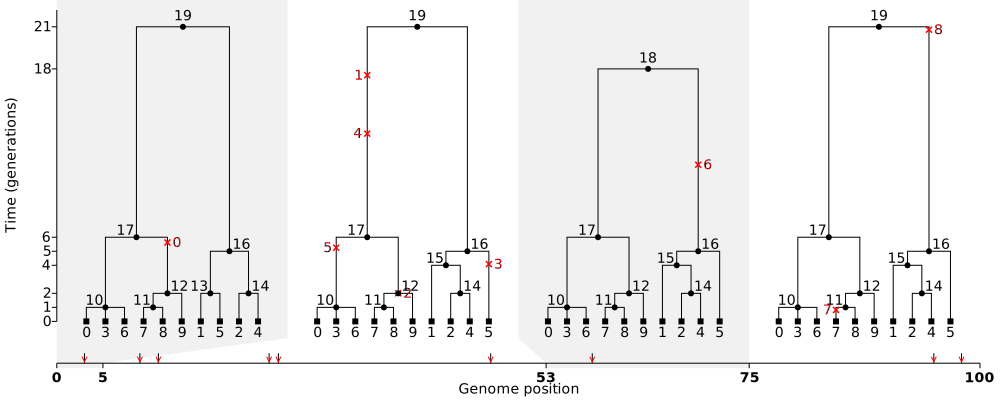

In [3]:
import msprime

no_muts_ts = ARG_workshop.FwdWrightFisherRecombSim(5, seq_len=100, recombination_rate=1e-3, random_seed=6).run(30)
ts = msprime.sim_mutations(no_muts_ts, rate=1e-3, random_seed=20)
display(ts.tables.sites)
display(ts.tables.mutations)
display(ts.draw_svg(y_axis=True, size=(1000, 400)))

<dl class="exercise"><dt>Exercise 1</dt>
<dd>Instead of the mutation IDs, it can be helpful to label the mutations with the previous state, the position and the derived state. In the cell below, use the <code>ARG_workshop.mutation_labels(ts)</code> function to create nicer mutation labels to pass to the <code>draw_svg()</code> function</dd>
</dl>

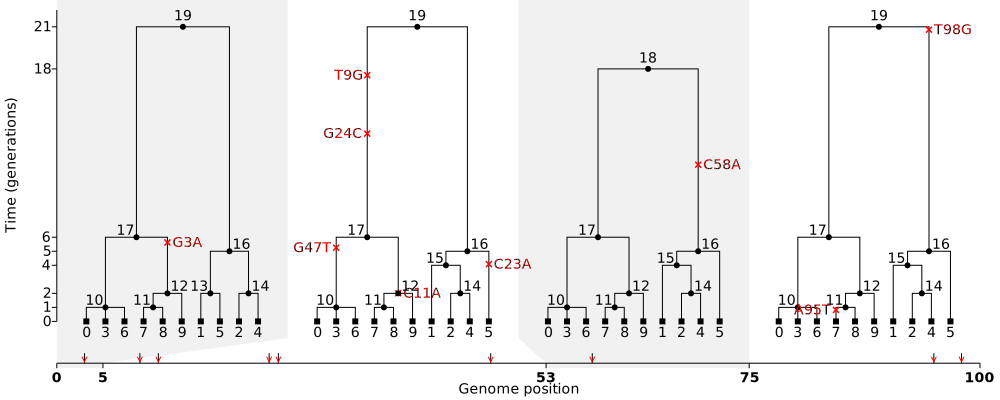

In [90]:
# Use draw_svg to replot the tree sequence with `mutation_labels=ARG_workshop.mutation_labels(ts)`


In [4]:
workbook.question("sites_and_mutations")

<IPython.core.display.Javascript object>

### _Tskit_ stores genetic variation efficiently
If you are storing genetic data for (say) a million genomes, using _tskit_ takes less space than conventional methods. That's because each variable site is encoded by a single or possibly a few mutations, rather than storing a million separate letters. Of course, you need to store the genealogy as well, but this too can be stored efficiently in _tskit_ (for example, adjacent trees are expected to differ by only a few (often one) SPRs, meaning only few edges change from tree-to-tree, even for genealogies of millions of samples).

### Decoding genetic variation

There are two ways to go through the sites programatically:
* the `.sites()` iterator returns a _tskit_ [Site](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Site) object, which includes a list of mutations
* the `.variants()` iterator additionally "decodes" the mutations, returning the [Site](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Site), a list of alleles, and an array specifying which samples have those alleles.

Below is an example of obtaining the `.alleles` and `.genotypes` attributes of the `.variants()` iterator.

In [91]:
import numpy as np
for v in ts.variants():
    pos = f"{v.site.position:3g}"  # The "site" object is also an attribute of a variant
    print(pos, v.alleles, v.genotypes, "==", np.array(v.alleles)[v.genotypes], sep="\t")

  3	('G', 'A')	[0 0 0 0 0 0 0 1 1 1]	==	['G' 'G' 'G' 'G' 'G' 'G' 'G' 'A' 'A' 'A']
  9	('T', 'G')	[1 0 0 1 0 0 1 1 1 1]	==	['G' 'T' 'T' 'G' 'T' 'T' 'G' 'G' 'G' 'G']
 11	('C', 'A')	[0 0 0 0 0 0 0 1 1 1]	==	['C' 'C' 'C' 'C' 'C' 'C' 'C' 'A' 'A' 'A']
 23	('C', 'A')	[0 0 0 0 0 1 0 0 0 0]	==	['C' 'C' 'C' 'C' 'C' 'A' 'C' 'C' 'C' 'C']
 24	('G', 'C')	[1 0 0 1 0 0 1 1 1 1]	==	['C' 'G' 'G' 'C' 'G' 'G' 'C' 'C' 'C' 'C']
 47	('G', 'T')	[1 0 0 1 0 0 1 0 0 0]	==	['T' 'G' 'G' 'T' 'G' 'G' 'T' 'G' 'G' 'G']
 58	('C', 'A')	[0 1 1 0 1 1 0 0 0 0]	==	['C' 'A' 'A' 'C' 'A' 'A' 'C' 'C' 'C' 'C']
 95	('A', 'T')	[0 0 0 0 0 0 0 1 0 0]	==	['A' 'A' 'A' 'A' 'A' 'A' 'A' 'T' 'A' 'A']
 98	('T', 'G')	[0 1 1 0 1 1 0 0 0 0]	==	['T' 'G' 'G' 'T' 'G' 'G' 'T' 'T' 'T' 'T']


It is also possible (but even less efficient) to decode the *haplotypes*: that is, the sequence of letters for each of a list of sample genomes:

In [92]:
nodes = [0, 1]
for node, hap in zip(nodes, ts.haplotypes(samples=nodes)):
    print(f"Sample {node}", hap)

Sample 0 GGCCCTCAT
Sample 1 GTCCGGAAG


The `.haplotypes()` method above only returns the *variable sites* along a 100 base pairs genome. If we want to show the whole sequence we can use the `.aligments()` method, as below:

Note: it's also possible to store a reference sequence in the tree sequence, in which case this can be used instead of the missing_data_charater. See XXX

In [93]:
for node, hap in zip(nodes, ts.alignments(samples=nodes, missing_data_character=".")):
    print(f"Sample {node}", hap)

Sample 0 ...G.....G.C...........CC......................T..........C....................................A..T.
Sample 1 ...G.....T.C...........CG......................G..........A....................................A..G.


It requires some computational effort to decode mutations and figure out the genotypes of the samples. However, this is often not necesary. Often, it's enough to know the local tree and the placement of the mutations within it. _Tskit_ contains a set of built-in [statistical routines]() that implement efficient calculations on genetic variation encoded in the tree sequence. These move along the genome, using the local tree directly and caching information used to calculate the statistics. This information is updated incrementally, when relevant parts of the local tree change, which makes the calculations much more efficient than running calculations on the decoded genotypes.

We'll run a larger example, based on the tutorials. This has a selective sweep

In [101]:
pop_size=10_000
seq_len=10_000_000

sweep_model = msprime.SweepGenicSelection(
    position=seq_len/2, start_frequency=0.0001, end_frequency=0.9999, s=0.25, dt=1e-6)

ts = msprime.sim_ancestry(
    500,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=pop_size,
    sequence_length=seq_len,
    recombination_rate=1e-8,
    random_seed=1234,  # only needed for repeatabilty
    )
ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=4321)
ts

In [102]:
# Calculating diversity on 1000 genomes & 25k sites is instantaneous
ts.diversity()

0.0002639252222222126

Exercise: plot windows of diversity.

# Site versus branch length statistics


In [ ]:
# Plot the edges

In [ ]:
# Exercise

In [ ]:

## Site vs branch length single site statistics

The allele frequency spectrum